# EE 400 Observations Project

by Victor, Filip, and Ziqiao


#### Note: The scripts below will automatically get the Likert Scale tables in an Observations .docx

#### Current Limitations and Ideas for Improvements:

- The desired entries of the tables in the observation forms **must begin with an 'X'**. An improvement would be to consider any text entry as a valid indicator of nonzero data.
- All other entries should be left blank. The program will convert blank entries to 0's.
- win32.Dispatch("Word.Application") will apparently open up any observation.docx inputted under some circumstances, so don't be alarmed if several Word documents open up as the script runs.

#### Resources:
- https://stackoverflow.com/questions/10366596/how-to-read-contents-of-an-table-in-ms-word-file-using-python/33775294#33775294
- https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html
- https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.plot.html

In [48]:
import numpy as np               # All-round useful
import scipy
import win32com.client as win32  # Necessary to get the Word docs
import pandas as pd              # Our main library to work with tabular data
import re                        # Used to find patterns in text for processing
import matplotlib.pyplot as plt  # Used for plotting
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Helper Function 1
def getData(table):
    '''
    Assumes: tables is take from a doc = word.ActiveDocument object
    Returns a delightful surprise: our data automatically formatted into beautiful DataFrame'''
    
    # Initialize
    data = [] 
    
    # Loop through all the rows and columns of the word docx table
    for j in range(1, len(table.Columns)+1): 
        col = [] # Initialize a column to fill up
        for i in range(1, len(table.Rows)+1):
            try:
                text = table.Cell(Row =i, Column =j).Range.Text 
                text = text.replace('\r\x07','') # Get rid of a weird mistranslated character
                text = text.replace('\r\x1f','')
                if j in range(2,len(table.Columns)) and i in range(2,len(table.Rows)):
                    text = text.replace(' ','')
                col.append(text) # add our text data to the column
            except:
                continue # if an exception is encountered just keep calm and carry on
        data.append(col)
    
    data = np.asarray(data).transpose() # Reorient the data to the original format
    return pd.DataFrame(data)

# Helper Function 2
def makeNums(df):
    '''
    Assumes dataframe is a pandas DataFrame with text values in the Likert Scale table
    Returns a pandas DataFrame with numerical values in the Likert Scale table
    Example:
            'Not at all' = 1
            'Somewhat' = 2
            'Satisfactory' = 3
            'Outstanding' = 4
    For details see:
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html
    '''  
    df = df.replace(to_replace=r'X', value=1, regex=True).replace('\rX',1) # Replace entries with X's with 1s 
    df = df.replace('',0)     # MAKE THE REG EXPRESSIONS BETTER. THIS IS NOT ROBUST.
    df.columns = df.iloc[0]   # Label the columns correctly
    df = df.drop(df.index[0]) # delete the redundant 0th row
    
    for i in range(1, len(list(df.columns))):    
        df.iloc[:, i] = df.iloc[:, i].replace(1,i) # gives the correct likert value to a column: 1,2,3,4
        
    return df

In [3]:
word = win32.Dispatch("Word.Application") # Not sure what this is but we need it
word.Visible = 0 # Not sure what this is but we need it

# Add the filepath as a string for convenience
path = "C:\\Users\\victo\\Desktop\\Observations-Project\\data\\"

filepaths = [path + "Observations_Form - AMATH 581.docx", # Start Victor's
             path + "Observations_Form - PHYS 116.docx",
             path + "Observations_Form - PHYS 123 Waves.docx",
             path + "Observations_Form - PHYS 114 General Physics.docx",
             path + "Observations_Form - CSE 421 Intro to Algorithms.docx",
             path + "Observations_Form - ME 123 Visualization and CAD.docx",
             path + "Observations_Form - ECE 235 Continuous Time Linear Systems.docx",
             path + "Observations_Form - MATH 126.docx",
             path + "Observations_Form - week 1.docx", # Start Filip's
             path + "Observations_Form - week 2.docx",
             path + "Observations_Form - week 3.docx",
             path + "Observations_Form - week 4.docx",
             path + "Observations_Form - week 5.docx",
             path + "Observations_Form - week 7.docx",
             path + "Observations_Form - week 8.docx", 
             path + "Observations_Form Week 1.docx", # Start Ziqiao's
             path + "Observations_Form Week 2.docx",
             path + "Observations_Form Week 3.docx",
             path + "Observations_Form Week 4.docx",
             path + "Observations_Form Week 5.docx",
             path + "Observations_Form 6 Ziqiao Xu.docx",
             path + "Observations_Form 7 Ziqiao Xu.docx",
             path + "Observations_Form 8 Ziqiao Xu.docx"]

In [4]:
instructor_ratings = [] # A matrix of all the instructor rating items: entry i is the data on observation i in the filepath
student_ratings = []    # A matrix of all the student rating items: entry i is the data on observation i in the filepath

for i in range(len(filepaths)):      # Loop over every observation document specified and dump the data into matrices
    word.Documents.Open(filepaths[i]) 
    doc = word.ActiveDocument        # Hold the tables in the word doc we're looking at
    instr1 = doc.Tables(1)           # 1st instructor table 
    instr2 = doc.Tables(2)           # 2nd instructor table
    students = doc.Tables(3)         # Student table

    df1 = getData(instr1) # returns a DataFrame of the word doc table data
    df1 = makeNums(df1)   # Relabels the entries to be either 0,1,2,3,4
    df2 = getData(instr2) 
    df2 = makeNums(df2)
    df_instr = pd.concat([df1,df2]).transpose() # Combine the instructor tables
    
    df_stud = getData(students)
    df_stud = makeNums(df_stud).transpose()  
    
    instructor_ratings.append(df_instr)
    student_ratings.append(df_stud)

# Fixes the labels for the instructor ratings. The concatenation resulted in 1-17, 1-13 instead of 1-30
for i in range(len(filepaths)):
    instructor_ratings[i].columns = list(range(1,31)) # Relabel column names

***
## 1. Cleaned Data:  

### Explanation:

The 43 Likert Scale items we are considering are split between two populations: Instructors and Students. Each numerical index corresponds to the relevant column in the ratings table or row in the descriptive statisitics table. Data such as the number of students enrolled in a given course and the number of students attending an observed class are given as a percentage. Observers are denoted as 1, 2 and 3 where relevant.

Likert Scale items are coded as 1, 2, 3, 4 corresponding to the four categories in the instructor ratings (Not at all, Somewhat, Satisfactory, and Outstanding) and as 1, 2, 3, 4, 5 corresponding to the five categories in your student ratings (None, Few, Some, Many, Most).

#### Instructor items:

1) The instructor provides objectives for the class session (written, verbal, or both). 

2) The instructor relates the session content to learning outcomes for the course.  

3) The instructor uses visual aids that are clear, organized, and relevant.     

4) The instructor uses practical, “real-world” examples to support teaching.   

5) The instructor refers to the relevant portions of the textbook, reading, or other supplement. 

6) The instructor uses humor effectively to promote student engagement and rapport. 

7) The instructor answers questions well and demonstrates knowledge of the subject.

8) The instructor shows clear interest or enthusiasm in teaching.

9) The instructor uses student names.

10) The instructor asks specific questions.  

11) The instructor pauses after asking a question.

12) The instructor asks questions of students that result in responses from students. 

13) The instructor changes gears periodically from one style of teaching to another.       

14) The instructor engages students periodically through think/pair/share, problem solving, or other active learning exercises.  

15) The instructor uses guided notes.

16) The instructor involves students periodically in what is to be covered during the session.

17) The instructor uses more than one way to explain problems or concepts.   

18) The opening of the class session gets students’ attention.

19) The instructor provides a summary of what has been covered and accomplished at the end of the observed session.  

20) The instructor provides a preview of the next session or ideas of what to consider for the next class at the end of the observed session.

21) The instructor could be easily heard.   

22) The instructor moves around in the classroom and refrains from standing/sitting in one place.

23) The instructor uses analogies or metaphors to relate the concepts to students’ experience.

24) The instructor emphasizes key points throughout the observed session.

25) The instructor makes eye contact with students.

26) The instructor uses open (not closed) body language during the observed session. 

27) The instructor engages in behaviors that develop rapport and trust with the students.  

28) The instructor relates the material/concepts to personal or societal concerns.

29) The instructor is available before class.

30) The instructor is available after class.

In [5]:
instructor_ratings[0] # Sample output for the 1st obsevation document

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,,,,,,,,,,,,,,,,,,,,,
During the Observed Session:,The instructor provides objectives for the cla...,The instructor relates the session content to ...,The instructor uses visual aids that are clear...,"The instructor uses practical, “real-world” ex...",The instructor refers to the relevant portions...,The instructor uses humor effectively to promo...,The instructor answers questions well and demo...,The instructor shows clear interest or enthusi...,The instructor uses student names.,The instructor asks specific questions.,...,The instructor could be easily heard.,The instructor moves around in the classroom a...,The instructor uses analogies or metaphors to ...,The instructor emphasizes key points throughou...,The instructor makes eye contact with students.,The instructor uses open (not closed) body lan...,The instructor engages in behaviors that devel...,The instructor relates the material/concepts t...,The instructor is available before class.,The instructor is available after class.
Not at All,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
Somewhat,0,2,0,2,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,2,0
Satisfactory,0,0,0,0,0,0,0,0,0,3,...,0,0,0,3,0,0,0,0,0,0
Outstanding,4,0,4,0,4,4,4,4,0,0,...,4,4,0,0,4,4,4,0,0,0


#### Student items:

1) Students maintain attention toward the instructor (for example – eye contact). 

2) Students remain awake and alert during the observed session.  

3) Students are using their cell phones or other electronic devices in activities unrelated to class.  

4) Students are over one minute late to class.   

5) Students pack up early at the end of class.   

6) Students are reading the newspaper or doing other non-electronic activities unrelated to class.   

7) Students interact with the instructor before class.

8) Students interact with the instructor after class.  

9) Students initiate questions.   

10) Students respond to questions posed by the instructor.

11) Students ask follow up questions.

12) Students participate in class when asked to do so by the instructor.     

13) Students are taking notes.

In [6]:
instructor_ratings[0] # Sample output for the 1st obsevation document out of len(filepaths) observations

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,,,,,,,,,,,,,,,,,,,,,
During the Observed Session:,The instructor provides objectives for the cla...,The instructor relates the session content to ...,The instructor uses visual aids that are clear...,"The instructor uses practical, “real-world” ex...",The instructor refers to the relevant portions...,The instructor uses humor effectively to promo...,The instructor answers questions well and demo...,The instructor shows clear interest or enthusi...,The instructor uses student names.,The instructor asks specific questions.,...,The instructor could be easily heard.,The instructor moves around in the classroom a...,The instructor uses analogies or metaphors to ...,The instructor emphasizes key points throughou...,The instructor makes eye contact with students.,The instructor uses open (not closed) body lan...,The instructor engages in behaviors that devel...,The instructor relates the material/concepts t...,The instructor is available before class.,The instructor is available after class.
Not at All,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
Somewhat,0,2,0,2,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,2,0
Satisfactory,0,0,0,0,0,0,0,0,0,3,...,0,0,0,3,0,0,0,0,0,0
Outstanding,4,0,4,0,4,4,4,4,0,0,...,4,4,0,0,4,4,4,0,0,0


***
## 2. Descriptive Statistics:   

- The descriptive statistics should also include mean, standard deviation, maximum, and minimum values of any scales that you select in subsequent analyses of the data (**a scale is an average of several items determined by exploratory factor analyses or similar statistical analysis technique to contain items that measure the same thing**).

#### Resources:
- https://chrisalbon.com/python/data_wrangling/pandas_rename_multiple_columns/
- https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/
- https://thispointer.com/python-pandas-how-to-add-rows-in-a-dataframe-using-dataframe-append-loc-iloc/
- https://note.nkmk.me/en/python-pandas-dataframe-rename/

In [7]:
def get_stats(ratings):
    '''
    Assumes: ratings is a matrix of all the (instructor or student) rating items
    Returns: A list containing the [mean, standard deviation, maximum, and minimum values] of 
             all relevant items over all observation forms for each criteria column
    '''
    allstats = []
 
    for col in range(1, len(ratings[0].columns)+1): # Iterate over the columns of criteria in the Likert Scale
        vals = []                                   # A list of the scores for a particular column over every observation: a (# of observations)x1 vector
        for i in range(len(filepaths)):             # Loop for every observation docx recorded
            vals.append(max(ratings[i][col][1:]))   # get the single nonzero evaluation score for a particular column
        max_vals = max(vals) 
        min_vals = min(vals)
        mean_vals = np.mean(vals)
        std_vals = np.std(vals)
        allstats.append([mean_vals, std_vals, max_vals, min_vals]) # vector of descriptive stats
    return allstats

***
The following table describes the mean, standard deviation, maximum, and minimum values of every class session observed between observes 1, 2, and 3 with respect to the student Likert Scale items.

In [8]:
# OUTPUT STUDENT DESCRIPTIVE STATS OVER ALL OBSERVATIONS
df_stud = pd.DataFrame(get_stats(student_ratings), index=range(1,14), columns=['Mean','Std','Max','Min'])
df_stud

,Mean,Std,Max,Min
1,4.043478,0.690196,5,3
2,4.565217,1.096480,5,0
3,2.565217,0.770437,4,1
4,2.826087,0.701066,4,2
5,2.391304,1.342908,5,0
6,1.608696,0.765514,4,1
7,1.565217,0.711770,3,1
8,2.000000,1.021508,4,0
9,2.217391,0.831788,3,0
10,2.826087,1.089562,5,1


***
Similarly, the following table describes the mean, standard deviation, maximum, and minimum values of every class session observed between observes 1, 2, and 3 with respect to the corresponding instructor Likert Scale items.

In [9]:
# OUTPUT INSTRUCTOR DESCRIPTIVE STATS OVER ALL OBSERVATIONS
df_instr = pd.DataFrame(get_stats(instructor_ratings), index=range(1,31), columns=['Mean','Std','Max','Min'])
df_instr

,Mean,Std,Max,Min
1,2.173913,0.916144,4,1
2,1.956522,1.041665,4,1
3,3.391304,0.641949,4,2
4,2.347826,1.004715,4,1
5,2.086957,1.176326,4,1
6,2.304348,1.195455,4,1
7,3.434783,0.770437,4,1
8,3.347826,0.758069,4,2
9,1.391304,0.871736,4,1
10,3.043478,0.858627,4,1


***
To elucidate these ideas further, we provide these statistics in a box plot format. The box plot items on the x-axis represent the overall mean, standard deviation, maximum, and minimum values, whereas the y-axis represents the spread of these items over every Likert Scale item. Green lines represent the average values, boxes indicate a higher concentration of values, black lines represent the 25% and 75%, and circles represent outliers.

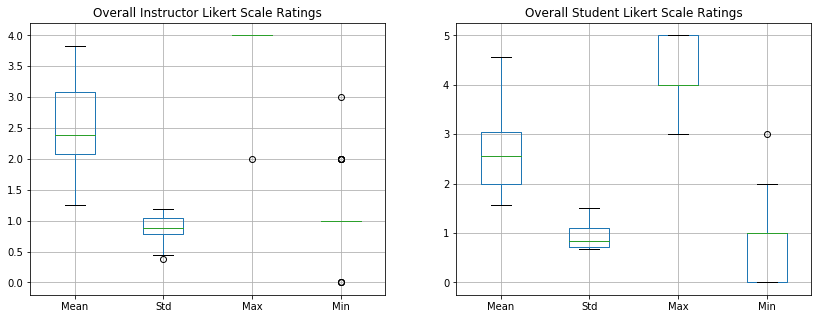

In [10]:
fig = plt.figure(figsize=(14,5))

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_instr.plot(kind='box', ax=ax1, grid=True, title='Overall Instructor Likert Scale Ratings');
df_stud.plot(kind='box', ax=ax2, grid=True, title='Overall Student Likert Scale Ratings');

Alternatively, we can view the data described above in a histogram.

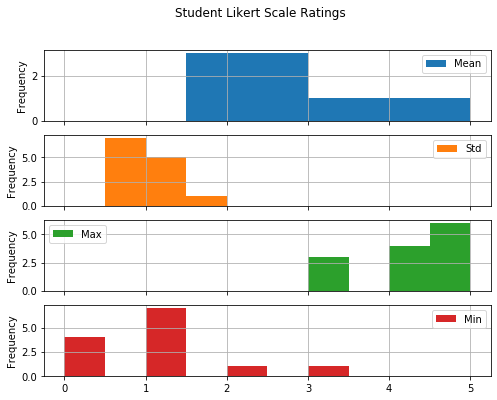

In [11]:
df_stud.plot(kind='hist', figsize=(8,6), subplots=True, grid=True, title='Student Likert Scale Ratings');

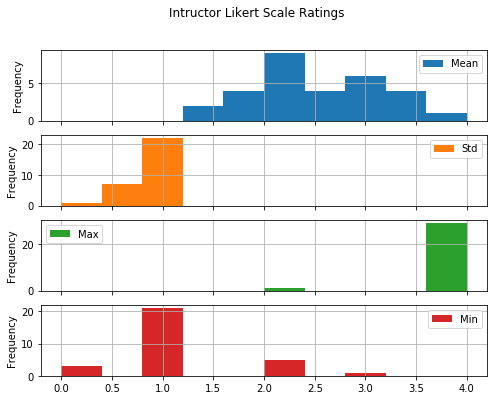

In [12]:
df_instr.plot(kind='hist', figsize=(8,6), subplots=True, grid=True, title='Intructor Likert Scale Ratings');

*** 
## 3. Exploratory Factor Analyses and Face Validity:   
 

Tasks:

- Use a principal components analysis on each set of data and take a look at the loadings to determine which items should be grouped into scales. 
    
    - https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60   
    
    - https://plot.ly/python/v3/ipython-notebooks/principal-component-analysis/

    - A rule of thumb is that items that load onto one factor at 0.5 or higher but do not load on another factor at 0.5 or higher can be grouped together into a scale. 
    

- The outcome of your exploratory factor analyses should be a brief paragraph describing which items you retained and which items you discarded (items that did not load well onto any factor or that cross-loaded onto multiple factors are typically discarded) and the names of the scales you decided on for your retained items.   


- Once you decide which items fit into which scales, take the average of the items to get the scale value and add the mean, standard deviation, maximum, and minimum to your descriptive statistics table.   

***
### Face Validity

In order to consider the face validity of the Likert Scale items, two catagories will be considered for instructors: behavioral and content-based. Student items will be considered to have the same face validity. 

#### Behavioral items: 
1, 3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17

#### Content-Based items: 
2, 4, 5, 7, 8, 18, 19, 20

In [13]:
def relabel(ratings):
    '''
    Assumes: ratings is a matrix of all the rating items: entry i is the data on observation i in the filepath
    Returns: the compressed ratings in a 1x(num. of criteria) table
    
    IMPORTANT: This function should only be called ONCE for a given set of ratings.
    '''
    for i in range(len(filepaths)):
        ratings[i].transpose()                                   # Sample output for the 1st obsevation document out of len(filepaths) observations
        cols = dict(ratings[i].transpose()[ratings[i].index[0]]) # The first row has the descriptions
        ratings[i].rename(columns=cols, inplace=True)            # Replace the old numerical col names with the descriptions
        ratings[i] = ratings[i].drop(ratings[i].index[0])        # Get rid of the redundant 1st row also with the descriptions
        
        # Compress the Likert Scale Table for a given observation into a singe row indicating the score
        score = pd.DataFrame([max(ratings[i].iloc[:,j]) for j in range(len(ratings[i].columns))]).transpose()
        
        cols = ratings[i].columns                                # Get the names of the columns
        cols = dict(enumerate(list(cols)))                       # turn the names into a dictionary: {1: 'The instructor...', 2: '...'}
        score.rename(columns=cols, inplace=True, index={0: 'Compressed Likert'}) # Label columns as the Likert Scale descriptions
        
        mod = ratings[i].append(score)                           # Append the compressed Likert Scale Table as the last row
        mod = mod.drop(mod.index[0:len(mod.index)-1])            # Get rid of the old redundant columns
        ratings[i] = mod                                         # Save the changes

In [14]:
# Should only be called once
relabel(instructor_ratings)
relabel(student_ratings)

In [15]:
all_instr_ratings = instructor_ratings[0] # initialize with the 1st observation
for i in range(1, len(instructor_ratings)): # Append all the compressed Likert Scale data: each row is an observation
    all_instr_ratings= all_instr_ratings.append(instructor_ratings[i], ignore_index=False, verify_integrity=False, sort=None)

In [16]:
all_instr_ratings.head()

,"The instructor provides objectives for the class session (written, verbal, or both).",The instructor relates the session content to learning outcomes for the course.,"The instructor uses visual aids that are clear, organized, and relevant.","The instructor uses practical, “real-world” examples to support teaching.","The instructor refers to the relevant portions of the textbook, reading, or other supplement.",The instructor uses humor effectively to promote student engagement and rapport.,The instructor answers questions well and demonstrates knowledge of the subject.,The instructor shows clear interest or enthusiasm in teaching.,The instructor uses student names.,The instructor asks specific questions.,...,The instructor could be easily heard.,The instructor moves around in the classroom and refrains from standing/sitting in one place.,The instructor uses analogies or metaphors to relate the concepts to students’ experience.,The instructor emphasizes key points throughout the observed session.,The instructor makes eye contact with students.,The instructor uses open (not closed) body language during the observed session.,The instructor engages in behaviors that develop rapport and trust with the students.,The instructor relates the material/concepts to personal or societal concerns.,The instructor is available before class.,The instructor is available after class.
Compressed Likert,4,2,4,2,4,4,4,4,2,3,...,4,4,1,3,4,4,4,1,2,1
Compressed Likert,4,1,4,2,4,4,4,4,1,4,...,4,4,4,4,4,4,4,2,3,2
Compressed Likert,2,1,4,2,4,4,4,4,1,2,...,4,2,3,4,4,3,3,2,4,3
Compressed Likert,1,1,3,2,1,2,3,2,1,2,...,4,2,2,2,3,2,2,2,4,4
Compressed Likert,2,1,3,2,1,2,3,3,1,2,...,4,2,1,4,4,3,2,2,4,2


Now we form the groups based on Face Validty in Python.

In [17]:
grp1 = np.array([1, 3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17]) - 1 # 1st group for Face Validity indices
grp2 = np.array([2, 4, 5, 7, 8, 18, 19, 20]) - 1 # 2nd group for Face Validity indices
face1 = all_instr_ratings.iloc[:, grp1] # Get the group's columns
face2 = all_instr_ratings.iloc[:, grp2]

In [18]:
all_stud_ratings = student_ratings[0]
for i in range(1, len(student_ratings)):
    all_stud_ratings= all_stud_ratings.append(student_ratings[i])

In [19]:
all_stud_ratings.head() # Show the first 5 observations

,Students maintain attention toward the instructor (for example – eye contact).,Students remain awake and alert during the observed session.,Students are using their cell phones or other electronic devices in activities unrelated to class.,Students are over one minute late to class.,Students pack up early at the end of class.,Students are reading the newspaper or doing other non-electronic activities unrelated to class.,Students interact with the instructor before class.,Students interact with the instructor after class.,Students initiate questions.,Students respond to questions posed by the instructor.,Students ask follow up questions.,Students participate in class when asked to do so by the instructor.,Students are taking notes.
Compressed Likert,5,5,1,2,1,1,3,1,3,3,1,5,5
Compressed Likert,5,5,2,3,3,2,1,2,2,4,2,5,5
Compressed Likert,4,5,2,3,3,2,1,2,3,2,2,5,4
Compressed Likert,4,4,2,2,5,2,1,2,1,1,1,5,1
Compressed Likert,3,3,3,2,0,2,2,1,2,2,1,2,2


Now we perform PCA on each instructor group and the single student group.

In [20]:
# Separating out the features
x = face1.values

# Separating out the target
y = pd.DataFrame(['grp1']*len(face1.index))

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

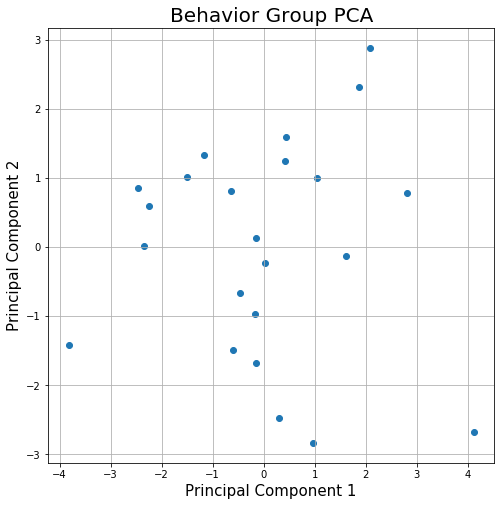

array([0.26783091, 0.19437144])

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Behavioral Group PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])

ax.grid()
plt.show()

pca.explained_variance_ratio_

In [22]:
# Separating out the features
x = face2.values

# Separating out the target
y = pd.DataFrame(['grp2']*len(face2.index))

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

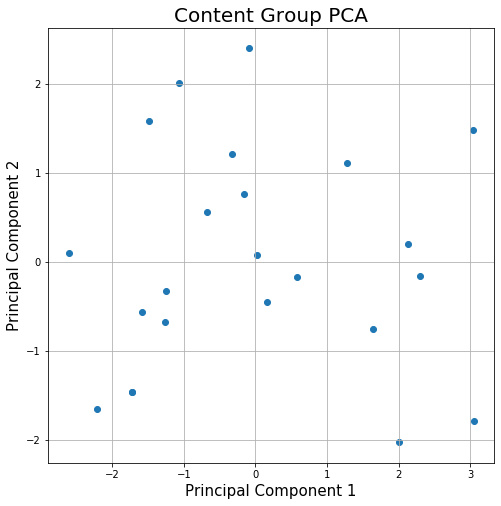

array([0.34929405, 0.18632904])

In [23]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Content-Based Group PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])

ax.grid()
plt.show()

pca.explained_variance_ratio_

Lastly, we consider this analysis on the student group.

In [24]:
# Separating out the features
x = all_stud_ratings.values

# Separating out the target
y = pd.DataFrame(['studs']*len(all_stud_ratings.index))

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

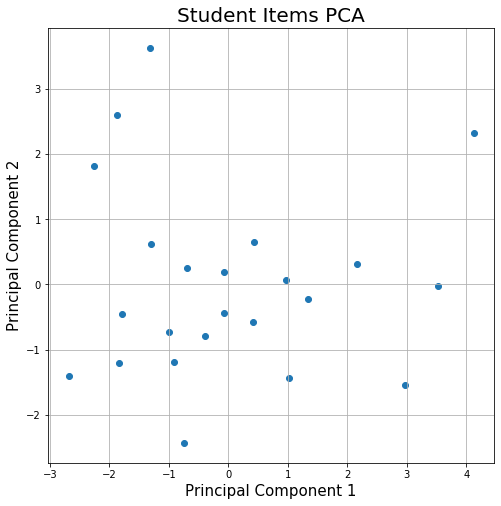

array([0.25390494, 0.156469  ])

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Student Items PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'])

ax.grid()
plt.show()

pca.explained_variance_ratio_

***
## 4. Inter-Rater Reliability:   

***

Observer codings:
- Observer 1's document refers to the data in `x`
- Observer 2's document refers to the data in `y`
- Observer 3's document refers to the data in `z`

For instructor items we calculate the Kendall Tau correlations. First, we consider the group observation of ME 123 Introduction to Visualization and CAD.

In [54]:
data = all_instr_ratings.transpose().iloc[:,[5,13,20]]
x,y,z = data.iloc[:,0].values, data.iloc[:,1].values, data.iloc[:,2].values

ME_instr = [scipy.stats.kendalltau(x, y), scipy.stats.kendalltau(x, z), scipy.stats.kendalltau(y, z)]

Next, we consider the group observation of ECE 235 Continuous Time Linear Systems.

In [55]:
data = all_instr_ratings.transpose().iloc[:,[6,14,21]]
x,y,z = data.iloc[:,0].values, data.iloc[:,1].values, data.iloc[:,2].values

EE_instr = [scipy.stats.kendalltau(x, y), scipy.stats.kendalltau(x, z), scipy.stats.kendalltau(y, z)]

Finally, we consider the group observation of MATH 126 Calculus. Note that there is only data for observers 1 and 3. 

In [56]:
data = all_instr_ratings.transpose().iloc[:,[7,22]]
x,y = data.iloc[:,0].values, data.iloc[:,1].values

MATH_instr = [scipy.stats.kendalltau(x, y)]

***
Similarly, for student items we have the following:

In [57]:
data = all_stud_ratings.transpose().iloc[:,[5,13,20]]
x,y,z = data.iloc[:,0].values, data.iloc[:,1].values, data.iloc[:,2].values

ME_stud = [scipy.stats.kendalltau(x, y), scipy.stats.kendalltau(x, z), scipy.stats.kendalltau(y, z)]

In [58]:
data = all_stud_ratings.transpose().iloc[:,[6,14,21]]
x,y,z = data.iloc[:,0].values, data.iloc[:,1].values, data.iloc[:,2].values

EE_stud = [scipy.stats.kendalltau(x, y), scipy.stats.kendalltau(x, z), scipy.stats.kendalltau(y, z)]

In [87]:
data = all_stud_ratings.transpose().iloc[:,[7,22]]
x,z = data.iloc[:,0].values, data.iloc[:,1].values

MATH_stud = [scipy.stats.kendalltau(x, z)]

***

We summarize these results in several tables, each described in turn. The first describes the Kendall Tau value between observers $1$ and $2$.

In [82]:
KT = {'Instructor Items': [ME_instr[0][0],EE_instr[0][0]], 'Student Items':[ME_stud[0][0],EE_stud[0][0]]}
df = pd.DataFrame(KT).transpose()
df.columns = ['ME 123','EE 235']
df

,ME 123,EE 235
Instructor Items,0.525667,0.631144
Student Items,0.357460,0.509647


The next table describes the Kendall Tau value between observers $1$ and $3$.

In [86]:
KT = {'Instructor Items': [ME_instr[1][0],EE_instr[1][0],MATH_instr[0][0]], 'Student Items':[ME_stud[1][0],EE_stud[1][0],MATH_stud[0][0]]}
df = pd.DataFrame(KT).transpose()
df.columns = ['ME 123','EE 235', 'MATH 126']
df

,ME 123,EE 235,MATH 126
Instructor Items,0.550677,0.477688,0.609953
Student Items,0.048038,0.524872,0.899468


The last table describes the Kendall Tau value between observers $2$ and $3$.

In [81]:
KT = {'Instructor Items': [ME_instr[2][0],EE_instr[2][0]], 'Student Items':[ME_stud[2][0],EE_stud[2][0]]}
df = pd.DataFrame(KT).transpose()
df.columns = ['ME 123','EE 235']
df

,ME 123,EE 235
Instructor Items,0.516613,0.599601
Student Items,0.701805,0.122883


### Discussions:

1) Did the rubrics help you to be more consistent? 


2) What could be modified to improve the reliability of your rating system?

***
1) Between observers $1$ and $2$, and $1$ and $3$, the data shows that, overall, the correlation between rankings of both instructor and student items grows stronger in subsequent observations. This corresponds well with the fact that our group had filled out more items on the shared rubric in those instances. However, it is interesting to note that the correlations between rankings in the student items for observer $2$ and $3$ dropped sharply even though the same rubric items were used. Compared with the other rankings, we consider this to be an outlier. 

2) To improve the reliability of our rating system we could add more explicit guidelines and criteria to each Likert scale item's rating and refine the language used in order to reduce any ambiguities that could lead to different interpretations. 

### Resources:
- https://www.statisticshowto.datasciencecentral.com/kendalls-tau/

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html